In [7]:
import  torch
import  networkx as nx
import  pandas as pd
from torch_geometric.data import Data
import  numpy as np

import matplotlib.pyplot as plt


## PyG
### data
**torch_geometric.data**中定义一些基本的图神经网络对象，最基本的两个是Data(同构图)和HeteroData()
#### Data(同构图)
Data把 **结点** 和 **边** 分开存储，类似与字典的键值对
\
构造函数Data对象:
```python
class Data(x: Optional[Tensor] = None, edge_index: Optional[Tensor] = None, edge_attr: Optional[Tensor] = None, y: Optional[Union[Tensor, int, float]] = None, pos: Optional[Tensor] = None, time: Optional[Tensor] = None, **kwargs)
```
\
参数含义:
- `x`:是结点特征，形状为`[num_nodes, num_node_features]`
- `edge_index`:图的边连接 ， COO形式([source1,source2....],[target1,target2....])，形状为`[2, num_edges] `，默认数据类型:`torch.long`
- `edge_attr`:边的特征矩阵，形状为` [num_edges, num_edge_features]`
- `y`:训练目标/标签（可能有任意形状），例如结点训练目标` [num_nodes, *]` or 图层面的标签 `[1, *]`
- `pos`: 位置矩阵 `[num_nodes, num_dimensions]`。pos 保存了节点在空间中的坐标，形状为 `[num_nodes, num_dimensions]`，其中 `num_nodes` 是节点的数量，`num_dimensions` 是空间的维度。例如，在2D空间的图中，pos 可能包含每个节点的 (x, y) 坐标；在3D空间中，则包含 (x, y, z)。
- time(torch.Tensor)-每个事件的时间戳，其形状为[Num_Edges]或[Num_Nodes]。(默认：无)
- **kwargs(可选)-其他属性。

\
属性(类型全部为torch.Tensor):
- data.x:结点特征 `[num_nodes, num_node_features]`

- data.edge_index:图的边连接 ， COO format([source1,source2....],[target1,target2....])，`[2, num_edges] ` 数据类型:` torch.long`

- data.edge_attr:边的特征矩阵 ` [num_edges, num_edge_features]`

- data.y: 训练目标/标签（可能有任意形状），例如结点训练目标` [num_nodes, *]` or 图层面的标签 `[1, *]`

- data.pos: 位置矩阵 `[num_nodes, num_dimensions]`
  
方法:
- `to_dict()`:返回存储的键/值对的字典，其中键是图的属性，例如特征x，边连接edige_index，值是对应的矩阵
- `to_namedtuple()`:返回存储的键/值对的NamedTuple。
- Update`:用另一个数据对象中的元素更新数据对象。添加的元素将覆盖现有的元素（在重复的情况下）。

- `__getitem__(self, key)`:用于获取图的属性。允许通过属性名作为键来访问图的任何属性，如 `data['x']` 返回节点特征矩阵。
- `__setitem__(self, key, item)`:用于设置图的属性。可以通过这个方法为图添加新的属性或修改现有的属性，如 `data['edge_attr'] = edge_features`。
- `__len__(self)`:返回图的节点数。这是通过检查节点特征矩阵的大小来实现的。

- `__contains__(self, key)`:检查图是否包含给定的属性。

- `__inc__(self, key, value)`:用于批处理时自增长某个属性的值。这通常用在 `edge_index` 上，以确保在批量处理多个图时，每个图的边索引是正确偏移的。

- `__cat_dim__(self, key, value)`:指定在批处理时应该沿哪个维度合并（拼接）特定属性。例如，节点特征(`x`)通常沿节点维度合并，而边索引(`edge_index`)不合并。

- `clone(self)`:返回 `Data` 对象的深拷贝。这个方法确保原始数据和拷贝数据在内存中是完全独立的。

- `to(device, **kwargs)`:将 `Data` 对象中的所有张量移动到指定的设备上（如GPU）。这对于深度学习训练非常有用。

-. `apply(func, *keys)`:对 `Data` 对象中的一个或多个属性应用函数 `func`。这对于数据预处理非常方便。

-. `contiguous(self, *keys)`:确保一个或多个属性的存储是连续的，这通常在将数据传递给某些特定操作之前需要。

-. `is_undirected(self)`:检查图是否是无向的。如果图的每条边都有对应的反向边，则认为图是无向的。


In [17]:
# edge_index存储方式[source1,source2....],[target1,target2.....]
# edge_index = torch.tensor([[0, 1 ,3,1,3,2,3,0],
#                            [1, 0 ,1,3,2,3,0,3]], dtype=torch.long)
# 如果要用[source1,target1],[ source2,target2]来存储，则需要transpose和 contiguous
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [3, 2],
                           [2, 3],
                           [3,0],
                           [0,3]], dtype=torch.long)
edge_index=edge_index.t().contiguous()
x = torch.randn(4, 2)
data = Data(x=x, edge_index=edge_index)
data.to_namedtuple()

GlobalStorageTuple(x=tensor([[-0.6434,  0.2935],
        [ 0.1403,  0.0367],
        [-0.0707, -0.6560],
        [-0.0719,  0.9992]]), edge_index=tensor([[0, 1, 3, 2, 3, 0],
        [1, 0, 2, 3, 0, 3]]))

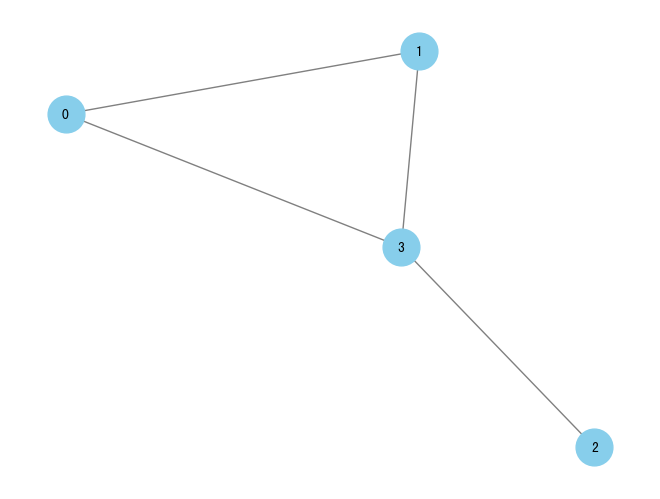

In [9]:
# NX 可视化图
# 创建无向图
G = nx.Graph()
# 添加节点
nodes = [0,1,2,3]
G.add_nodes_from(nodes)
# 添加边（连接关系）
# (第一种形式的推导式)
edges = [(edge_index[0, i].item(), edge_index[1, i].item())
                      for i in range(edge_index.shape[1])]
# 第二中形式的推导式
# edges=[tuple(x.tolist())for x in edge_index]
G.add_edges_from(edges)
# 可视化图
pos = nx.spring_layout(G)  # 选择布局算法
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700,
        node_color='skyblue', font_size=10, edge_color='gray')
# 获取邻接矩阵
adj_matrix = nx.adjacency_matrix(G)
# 获取度矩阵
degree_matrix = np.diag(list(dict(G.degree).values()))

In [10]:
# 内建数据集
from torch_geometric.datasets import TUDataset, CoraFull
from torch_geometric.datasets import Planetoid

# dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = Planetoid(root='/tmp/Cora', name='Cora')
print(len(dataset),dataset.num_classes,dataset.num_node_features)

ServerDisconnectedError: Server disconnected

## 异构图 Hetero_graph
### 创建异构图
异构图创建一般是先创建一个空的异构图，然后在添加节点和边
```python
from torch_geometric.data import HeteroData
hetero_data = HeteroData()#创建空异构图
```

### 节点
- 添加新的节点类
异构图的存储类似与字典，因此可以直接通过下标来添加新的节点类\
`hetero_data['new_node_type'].x = torch.randn(num_nodes,num_nodes_features)`
- 添加新结点:由于节点的存储是矩阵，每一行是一个结点，因此只需要创建相同特征的`tensor`并且`cat`到特征矩阵x上即可:\
`new_nodes_features = torch.randn(2, 4)`\
`hetero_data['existing_node_type'].x = torch.cat([hetero_data['existing_node_type'].x, new_nodes_features], dim=0)`

### 边
- 添加边的范式:\
`hetero_graph['source', 'relation', 'target'].edge_index=torch.tensor[source_list,target_list]`\
例如:假设第1种农药可以防治第1种和第2种病害\
`hetero_graph['pesticide', 'prevents', 'disease'].edge_index = torch.tensor([[0, 0], [0, 1]])`\
- 可以通过`edge_attr`来构建边的特征\
`hetero_graph['pesticide', 'prevents', 'disease'].edge_attr = torch.randn(2, 2)`

In [ ]:
import torch
from torch_geometric.data import HeteroData
# 创建HeteroData对象
hetero_graph = HeteroData()

# 假设我们有3种农药，每种农药的特征维度为5
hetero_graph['pesticide'].x = torch.randn(3, 5)
# 假设有4种病害，每种病害的特征维度为5
hetero_graph['disease'].x = torch.randn(4, 5)

# 假设有2种植物，每种植物的特征维度为5
hetero_graph['plant'].x = torch.randn(2, 5)
# 定义农药到病害的"防治"关系
# 假设第1种农药可以防治第1种和第2种病害
hetero_graph['pesticide', 'prevents', 'disease'].edge_index = torch.tensor(
    [[0, 0], [0, 1]], dtype=torch.long)

# 定义病害到植物的"影响"关系
# 假设第1种病害影响第1种植物，第2种和第3种病害影响第2种植物
hetero_graph['disease', 'affects', 'plant'].edge_index = torch.tensor(
    [[0, 1, 2], [0, 1, 1]], dtype=torch.long)
# 为"防治"关系添加特征，假设特征维度为2
hetero_graph['pesticide', 'prevents', 'disease'].edge_attr = torch.randn(2, 2)
# 为"影响"关系添加特征，假设特征维度为3
hetero_graph['disease', 'affects', 'plant'].edge_attr = torch.randn(3, 2)
hetero_graph

HeteroData(
  pesticide={ x=[3, 5] },
  disease={ x=[4, 5] },
  plant={ x=[2, 5] },
  (pesticide, prevents, disease)={
    edge_index=[2, 2],
    edge_attr=[2, 2],
  },
  (disease, affects, plant)={
    edge_index=[2, 3],
    edge_attr=[3, 2],
  }
)